# Machine Learning Model
### In this note book, I am tring machine models for regression the question

In [11]:
# data engineer
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor
import pandas as pd
import numpy as np
import math
import queue
from pprint import pprint
from sklearn.ensemble import IsolationForest
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline
FILE_FOLDER = '../prediction_data/%s'
AFTER_FILE_FOLDER = '../prediction_data/afterAnalysis/%s'

In [2]:
train_data = pd.read_csv(AFTER_FILE_FOLDER % 'train_data_after_first_filling.csv')
train_data.columns

Index(['Unnamed: 0', 'station_id', 'time', 'temperature', 'humidity',
       'pressure', 'wind_speed', 'PM25', 'PM10', 'O3'],
      dtype='object')

In [3]:
test_data = pd.read_csv(AFTER_FILE_FOLDER % 'test_data.csv')
test_data = test_data[['temperature', 'humidity','pressure', 'wind_speed']]
print(test_data['humidity'].describe())
print(test_data['pressure'].describe())

count    1680.000000
mean       34.857149
std        17.459168
min        10.820000
25%        22.145000
50%        29.735000
75%        47.207500
max        85.220000
Name: humidity, dtype: float64
count    1680.000000
mean     1002.729786
std        14.655869
min       941.590000
25%      1000.060000
50%      1008.320000
75%      1011.622500
max      1017.110000
Name: pressure, dtype: float64


In [4]:
df_train = train_data[['temperature', 'humidity',
       'pressure', 'wind_speed', 'PM25', 'PM10', 'O3']]

In [5]:
df_train_labels = df_train[['PM25','PM10','O3']]

df_train_labels['PM25IsNan'] = df_train_labels['PM25'].isnull()
df_train_labels['PM10IsNan'] = df_train_labels['PM10'].isnull()
df_train_labels['O3IsNan'] = df_train_labels['O3'].isnull()


print('total cols',len(df_train_labels))
len(df_train_labels[df_train_labels['PM25IsNan'] == True]),len(df_train_labels[df_train_labels['PM10IsNan'] == True]),len(df_train_labels[df_train_labels['O3IsNan'] == True])

total cols 153160


(35, 2310, 35)

In [6]:
df_train_copy = df_train.copy()
df_train_withoutNAN = df_train_copy.dropna()
print('len after removing nan:', len(df_train_withoutNAN))

len after removing nan: 150850


# Handing the outliers

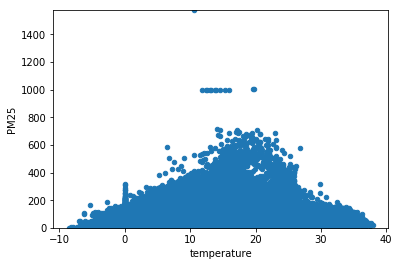

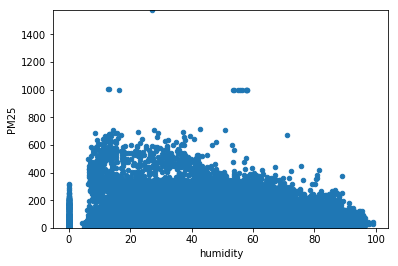

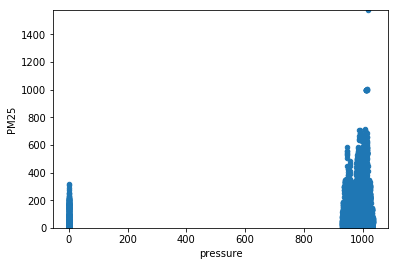

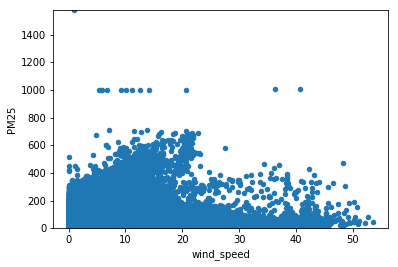

In [7]:
columnsList_num = ['temperature', 'humidity', 'pressure', 'wind_speed']
for i in columnsList_num:
    var = i
    data = pd.concat([df_train_withoutNAN['PM25'], df_train_withoutNAN[var]], axis=1)
    data.plot.scatter(x=var, y='PM25', ylim=(df_train_withoutNAN['PM25'].min(),df_train_withoutNAN['PM25'].max()))

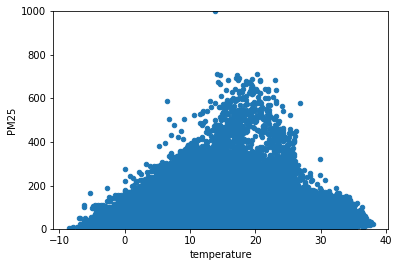

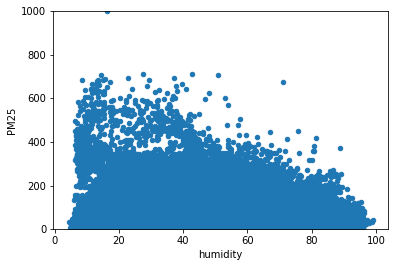

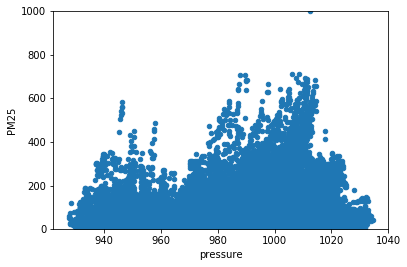

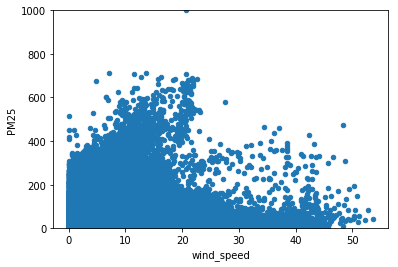

In [8]:
df_train_new = df_train_withoutNAN[df_train_withoutNAN['PM25'] < 1000]
df_train_new = df_train_new[df_train_new['humidity'] > 0]
df_train_new = df_train_new[df_train_new['pressure'] > 0]
columnsList_num = ['temperature', 'humidity', 'pressure', 'wind_speed']
for i in columnsList_num:
    var = i
    data = pd.concat([df_train_new['PM25'], df_train_new[var]], axis=1)
    data.plot.scatter(x=var, y='PM25', ylim=(df_train_new['PM25'].min(),df_train_new['PM25'].max()));

In [9]:
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit_predict(pd.get_dummies(df_train_new))
y_noano = clf.predict(df_train_new)
y_noano = pd.DataFrame(y_noano, columns=['Top'])
df_train_data = df_train_new.iloc[y_noano[y_noano['Top'] == 1].index.values]
df_train_data.reset_index(drop=True, inplace=True)
print(len(df_train_data))

135179


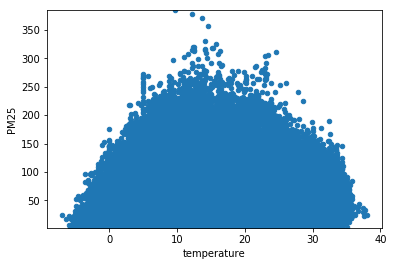

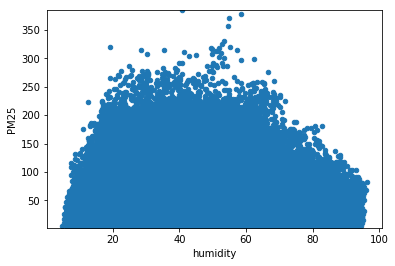

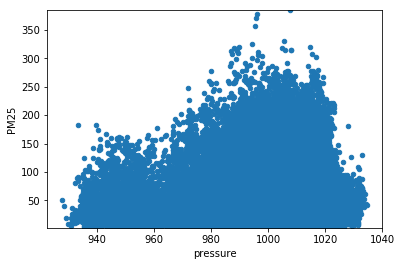

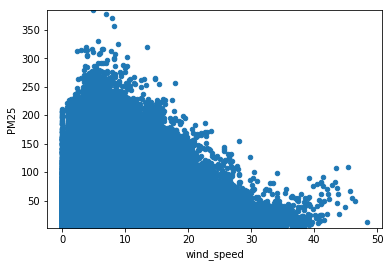

In [10]:
columnsList_num = ['temperature', 'humidity', 'pressure', 'wind_speed']
for i in columnsList_num:
    var = i
    data = pd.concat([df_train_data['PM25'], df_train_data[var]], axis=1)
    data.plot.scatter(x=var, y='PM25', ylim=(df_train_data['PM25'].min(),df_train_data['PM25'].max()));

# Illustrate the distribution

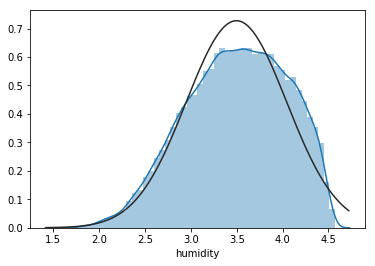

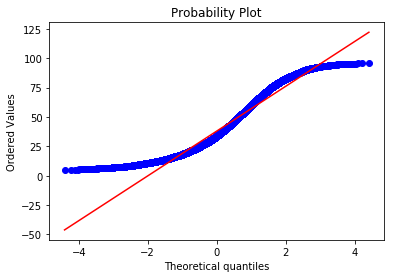

In [11]:
# df_train['time'].describe()
sns.distplot(np.log(df_train_data['humidity']), fit=norm)
fig = plt.figure()
res = stats.probplot((df_train_data['humidity']), plot=plt)

# columnsList_num = ['temperature', 'humidity', 'pressure', 'wind_speed']

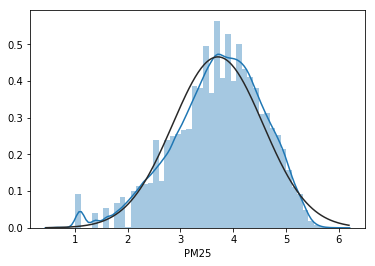

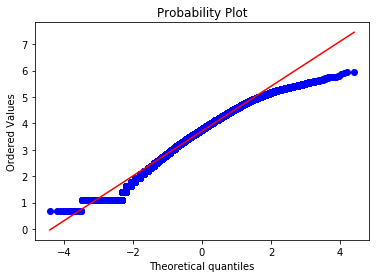

In [12]:
# df_train['time'].describe()
sns.distplot(np.log(df_train_data['PM25']), fit=norm)
fig = plt.figure()
res = stats.probplot(np.log(df_train_data['PM25']), plot=plt)

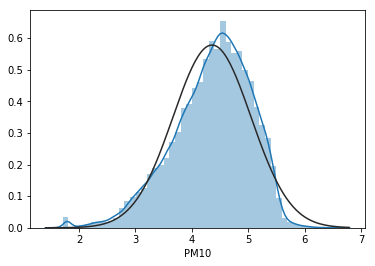

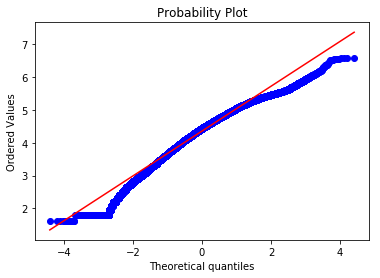

In [13]:
# df_train['time'].describe()
sns.distplot(np.log(df_train_data['PM10']), fit=norm)
fig = plt.figure()
res = stats.probplot(np.log(df_train_data['PM10']), plot=plt)

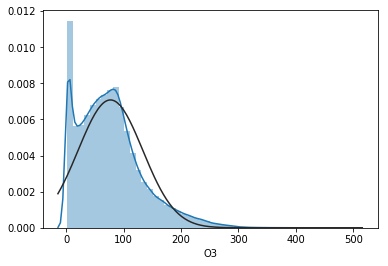

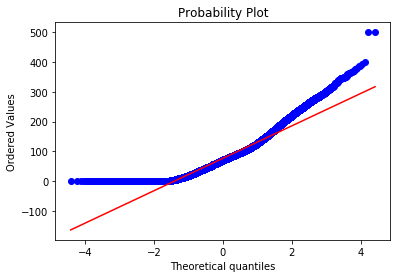

In [14]:
# df_train['time'].describe()
sns.distplot(df_train_data['O3'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train_data['O3'], plot=plt)

In [15]:
df_train_data['PM25_log'] = np.log(df_train_data['PM25'])
df_train_data['PM10_log'] = np.log(df_train_data['PM10'])

# Model selection
### For PM 2.5

In [55]:
df_train_features_pm25 = df_train_data[['temperature', 'humidity','pressure', 'wind_speed']]
df_label_pm25 = df_train_data['PM25']

mean_pm25 = df_train_features_pm25.mean(axis=0)
std_pm25 = df_train_features_pm25.std(axis=0)
df_train_features_pm25 = (df_train_features_pm25 - mean)/std

## Esembale Learning models

In [63]:
def cross_validation(X,y,model,model_name):
    my_pipeline = make_pipeline(SimpleImputer(), model)
    scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error',cv=4)
    print(scores)
    print('%s: '%model_name)
    print('Mean Absolute Error %3f\n' % (-1 * scores.mean()))
    
def models_selection(X,y):
    cross_validation(X, y.values.ravel(),XGBRegressor(),'XGBRegressor')
    
    cross_validation(X, y.values.ravel(), 
                     ExtraTreesRegressor(n_estimators=500, random_state=0),'ExtraTreesRegressor')
    
    cross_validation(X, y.values.ravel(), 
                     RandomForestRegressor(n_estimators=500,random_state=0),'RandomForestRegressor')
    
    cross_validation(X, y.values.ravel(), 
                     AdaBoostRegressor(n_estimators=500, random_state=0),'AdaBoostRegressor')
    
    universal_model = MLPRegressor(hidden_layer_sizes=(5,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01)
    cross_validation(X, y.values.ravel(),universal_model,'MLPRegressor')
    
    cross_validation(X, y.values.ravel(),linear_model.LinearRegression(),'LinearRegression')

In [69]:
models_selection(df_train_features_pm25,df_label_pm25)

[-0.67467618 -0.51409671 -0.53832518 -0.75024051]
XGBRegressor: 
Mean Absolute Error 0.619335

[-0.63766571 -0.42686484 -0.47012091 -0.74255656]
ExtraTreesRegressor: 
Mean Absolute Error 0.569302

[-0.63980615 -0.43397364 -0.4796267  -0.75146709]
RandomForestRegressor: 
Mean Absolute Error 0.576218

[-0.737526   -0.52628573 -0.57088221 -0.76847492]
AdaBoostRegressor: 
Mean Absolute Error 0.650792

[-0.67973851 -0.52765126 -0.59372588 -0.74794572]
MLPRegressor: 
Mean Absolute Error 0.637265

[-0.77813303 -0.57851632 -0.58610736 -0.75704795]
LinearRegression: 
Mean Absolute Error 0.674951



## NN models

In [60]:
from sklearn.neural_network import MLPRegressor

universal_model = MLPRegressor(hidden_layer_sizes=(5,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01)

In [61]:
cross_validation(df_train_features_pm25, df_label_pm25.values.ravel(),
                 universal_model,'MLPRegressor')

[-32.87930483 -29.29948116 -30.56711261 -40.15384476]
MLPRegressor: 
Mean Absolute Error 33.224936



### Train for PM2.5

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split

In [19]:
pm25_model = ExtraTreesRegressor(n_estimators=500, random_state=0)

In [20]:
train_X, val_X, train_y, val_y = train_test_split(df_train_features_pm25, df_label_pm25,random_state=512)
pm25_model.fit(train_X,train_y)
predicted_y = pm25_model.predict(val_X)
print("error:", mean_squared_error(predicted_y, val_y))

error: 1056.5719836258136


In [23]:
pkl_filename = AFTER_FILE_FOLDER%'pm25_model.pkl'
with open(pkl_filename, 'wb') as file:  
    pickle.dump(pm25_model, file)

OSError: [Errno 22] Invalid argument

### For PM 10

In [65]:
df_train_features_pm10 = df_train_data[['temperature', 'humidity','pressure', 'wind_speed','PM25']]
df_label_pm10 = df_train_data['PM10'] / 750.0

mean_pm10 = df_train_features_pm10.mean(axis=0)
std_pm10 = df_train_features_pm10.std(axis=0)
df_train_features_pm10 = (df_train_features_pm10 - mean)/std
df_label_pm10

In [65]:
models_selection(df_train_features_pm10,df_label_pm10)

[-26.7799048  -22.68246034 -23.83408304 -33.43142917]
XGBRegressor: 
Mean Absolute Error 26.681969

[-27.48934136 -20.8723069  -22.33147332 -33.27384799]
ExtraTreesRegressor: 
Mean Absolute Error 25.991742

[-27.4800713  -20.78145537 -22.41950421 -33.26037004]
RandomForestRegressor: 
Mean Absolute Error 25.985350

[-52.80667637 -33.34985414 -57.63796157 -54.47022617]
AdaBoostRegressor: 
Mean Absolute Error 49.566180

[-28.1772629  -24.23914869 -24.32376401 -34.53656274]
MLPRegressor: 
Mean Absolute Error 27.819185

[-28.94475576 -24.91785764 -26.27826829 -35.75938299]
LinearRegression: 
Mean Absolute Error 28.975066



In [66]:
pm10_model = ExtraTreesRegressor(n_estimators=500, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(df_train_features_pm10, df_label_pm10,random_state=512)
pm10_model.fit(train_X,train_y)
predicted_y = pm10_model.predict(val_X)
print("no log error:", mean_squared_error(predicted_y, val_y))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### For O3

In [56]:
df_train_features_O3 = df_train_data[['temperature', 'humidity','pressure', 'wind_speed']]
df_label_O3 = df_train_data['O3']

mean_o3 = df_train_features_O3.mean(axis=0)
std_o3 = df_train_features_O3.std(axis=0)
df_train_features_O3 = (df_train_features_O3 - mean)/std

In [67]:
models_selection(df_train_features_O3,df_label_O3)

[-25.72080536 -33.80030371 -32.83562088 -26.19122162]
XGBRegressor: 
Mean Absolute Error 29.636988

[-24.78865453 -30.17999697 -29.89527553 -26.47410107]
ExtraTreesRegressor: 
Mean Absolute Error 27.834507

[-24.93148922 -30.67399313 -30.52230543 -26.7356384 ]
RandomForestRegressor: 
Mean Absolute Error 28.215857

[-29.37771281 -38.9885041  -62.31784841 -28.42169156]
AdaBoostRegressor: 
Mean Absolute Error 39.776439

[-26.36935836 -35.45668818 -34.6847354  -27.70171187]
MLPRegressor: 
Mean Absolute Error 31.053123

[-29.22965717 -40.44545903 -36.96352305 -28.70583178]
LinearRegression: 
Mean Absolute Error 33.836118



In [29]:
O3_model = ExtraTreesRegressor(n_estimators=500, random_state=0)
train_X, val_X, train_y, val_y = train_test_split(df_train_features_O3, df_label_O3,random_state=512)
O3_model.fit(train_X,train_y)
predicted_y = O3_model.predict(val_X)
print("no log error:", mean_squared_error(predicted_y, val_y))

no log error: 1020.9843211277189


# Filling Missing Data by Model
## PM25

In [12]:
# df_aq_with_weather = pd.read_csv(AFTER_FILE_FOLDER % 'aq_with_weather.csv')
# df_aq_with_weather[df_aq_with_weather['O3'].isnull()]
# df_aq_with_weather['time'] = pd.to_datetime(df_aq_with_weather['time'])
# df_aq_with_weather['year'] = df_aq_with_weather['time'].dt.year
# df_aq_with_weather['month'] = df_aq_with_weather['time'].dt.month
# df_aq_with_weather['day'] = df_aq_with_weather['time'].dt.day
# df_aq_with_weather['hour'] = df_aq_with_weather['time'].dt.hour
df_aq_with_weather = pd.read_csv(AFTER_FILE_FOLDER % 'after_first_filling.csv')

time_columns = ['year', 'month', 'day', 'hour']
weather_columns = ['temperature', 'humidity', 'pressure','wind_speed']
# labels_columns = ['PM25', 'PM10', 'O3']
labels_columns = ['O3']

In [13]:
pre_models = {}
mean_dic = {}
std_dic = {}
label_max_dic = {}
for p in labels_columns:
    label = df_aq_with_weather[~df_aq_with_weather[p].isnull()][p]
    df_features = df_aq_with_weather[~df_aq_with_weather[p].isnull()][weather_columns + time_columns]
    
    mean = df_features[weather_columns].mean(axis=0)
    std = df_features[weather_columns].std(axis=0)
    df_features[weather_columns] = (df_features[weather_columns] - mean) / std
    label_max = label.max()
    print(label_max)
    label = label / label_max
#     print(df_features)
    model = ExtraTreesRegressor(n_estimators=500, random_state=0)
    model.fit(df_features,label)
    
    pre_models[p] = model
    mean_dic[p] = mean
    std_dic[p] = std
    label_max_dic[p] = label_max
    

504.0


In [14]:
def fill_missing_byModel(df_aq):
    df_aq_copy = df_aq.copy()
    for p in ['O3']:

        df_null = df_aq[df_aq[p].isnull()][weather_columns + time_columns]
        mean = mean_dic[p]
        std = std_dic[p]
        df_null[weather_columns] = (df_null[weather_columns] - mean) / std
        
        model = pre_models[p]
        pre_y = model.predict(df_null)
        
        point_i = 0
        for index, row in df_null.iterrows():
            df_aq_copy.at[index,p] = pre_y[point_i] * label_max_dic[p]
            point_i += 1
    return df_aq_copy

In [15]:
after_filling = fill_missing_byModel(df_aq_with_weather)

In [16]:
after_filling.to_csv(AFTER_FILE_FOLDER % 'after_second_filling.csv',index=False)

In [17]:
after_filling

,station_id,time,temperature,humidity,pressure,wind_speed,PM25,PM10,O3,year,month,day,hour
0,dongsi_aq,2017-01-01 00:00:00,-5.943333,70.966667,1021.273333,4.553333,303.891500,298.837650,4.435270,2017,1,1,0
1,dongsi_aq,2017-01-01 01:00:00,-3.466667,60.483333,1021.153333,4.066667,345.389000,349.060384,5.033449,2017,1,1,1
2,dongsi_aq,2017-01-01 02:00:00,-0.993333,50.006667,1021.036667,3.670000,361.419600,363.425061,7.225380,2017,1,1,2
3,dongsi_aq,2017-01-01 03:00:00,1.483333,39.526667,1020.913333,3.390000,315.208842,319.455446,14.034474,2017,1,1,3
4,dongsi_aq,2017-01-01 04:00:00,2.640000,36.936667,1020.220000,3.996667,308.893372,299.654125,16.663295,2017,1,1,4
5,dongsi_aq,2017-01-01 05:00:00,3.800000,34.340000,1019.523333,4.616667,325.867459,276.214842,22.470119,2017,1,1,5
6,dongsi_aq,2017-01-01 06:00:00,4.956667,31.750000,1018.830000,5.243333,328.949608,265.535867,31.794717,2017,1,1,6
7,dongsi_aq,2017-01-01 07:00:00,2.806667,38.986667,1018.770000,5.560000,349.082299,307.778982,30.133440,2017,1,1,7
8,dongsi_aq,2017-01-01 08:00:00,0.650000,46.223333,1018.710000,5.913333,382.137000,345.502980,23.374030,2017,1,1,8
9,dongsi_aq,2017-01-01 09:00:00,-1.500000,53.463333,1018.650000,6.306667,387.888000,366.383850,19.726470,2017,1,1,9
